The purpose of this notebook is to illustrate some methods of interpreting the Machine Learning models (many times also called as Black Box models) for their so called 'Lack of Interpretability. I will also show a few methods of ensemling various models to achieve better results than any single model.

Warning: The model hyperparameters given in each of modle types are for illustration purposes only. They are not the recommended values and the user should do a separate round of hyperparameter tuning to achieve better results

Credits:

https://www.linkedin.com/in/serigne-cisse-15209b41/


https://github.com/vecxoz/vecstack


In [1]:
##Setting up the basic libraries
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew 


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [2]:
dataloc = "C://Users//sandip.bhattacharjee//Desktop//OE-Series//Part1//house-prices-advanced-regression-techniques//"

In [3]:
train = pd.read_csv(dataloc + "train.csv")
test = pd.read_csv(dataloc + "test.csv")
train.shape,test.shape

((1460, 81), (1459, 80))

# Analyze Target Variable first


 mu = 180921.20 and sigma = 79415.29



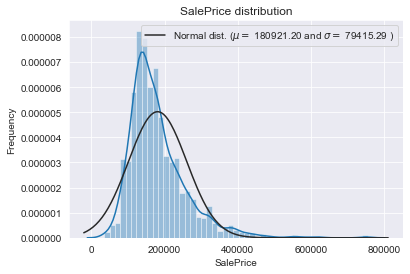

In [4]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.show()

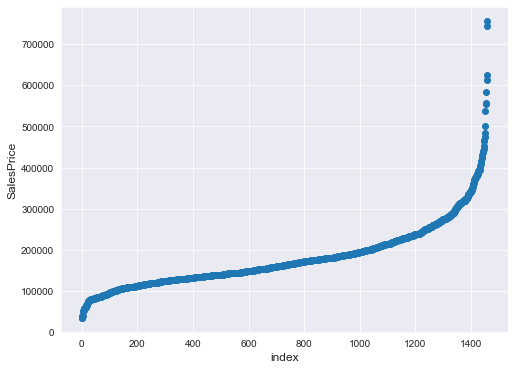

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.SalePrice.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('SalesPrice', fontsize=12)
plt.show()

The distribution looks left skewed along with quite a few outliers on the top end. Let's do a log transformation and see if the situation imporves.


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'Log SalePrice distribution')

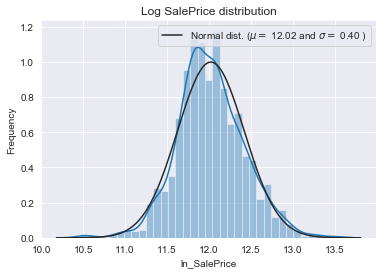

In [6]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["ln_SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['ln_SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['ln_SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log SalePrice distribution')

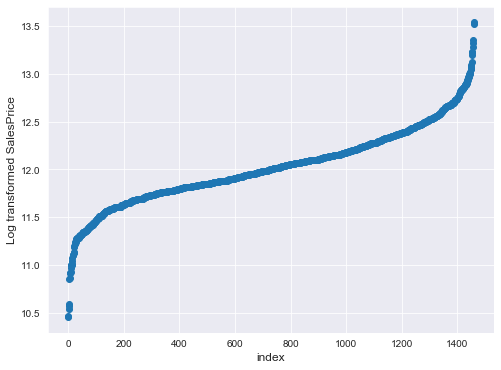

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.ln_SalePrice.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Log transformed SalesPrice', fontsize=12)
plt.show()

Now it seems that there are outliers at both ends. Let's do a outlier removal and plot again.

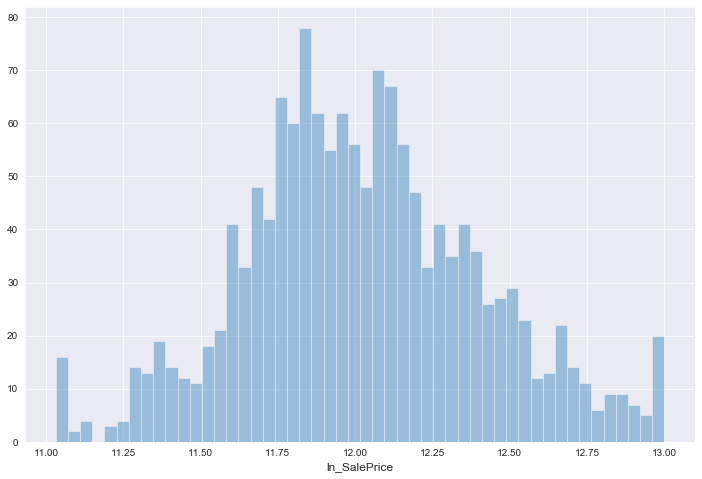

In [8]:
ulimit = np.percentile(train.ln_SalePrice.values, 99)
llimit = np.percentile(train.ln_SalePrice.values, 1)
train['ln_SalePrice'].ix[train['ln_SalePrice']>ulimit] = ulimit
train['ln_SalePrice'].ix[train['ln_SalePrice']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train.ln_SalePrice.values, bins=50, kde=False)
plt.xlabel('ln_SalePrice', fontsize=12)
plt.show()

Now this resembles a little more like a Normal distribution

# Feature Engineering

Let's first check for missing data

In [9]:
def check_miss_data(df, topn):
    df_na = (df.isnull().sum() / len(df)) * 100
    df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:topn]
    missing_data = pd.DataFrame({'Missing Ratio' :df_na})
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=df_na.index, y=df_na)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    plt.show()
    return missing_data

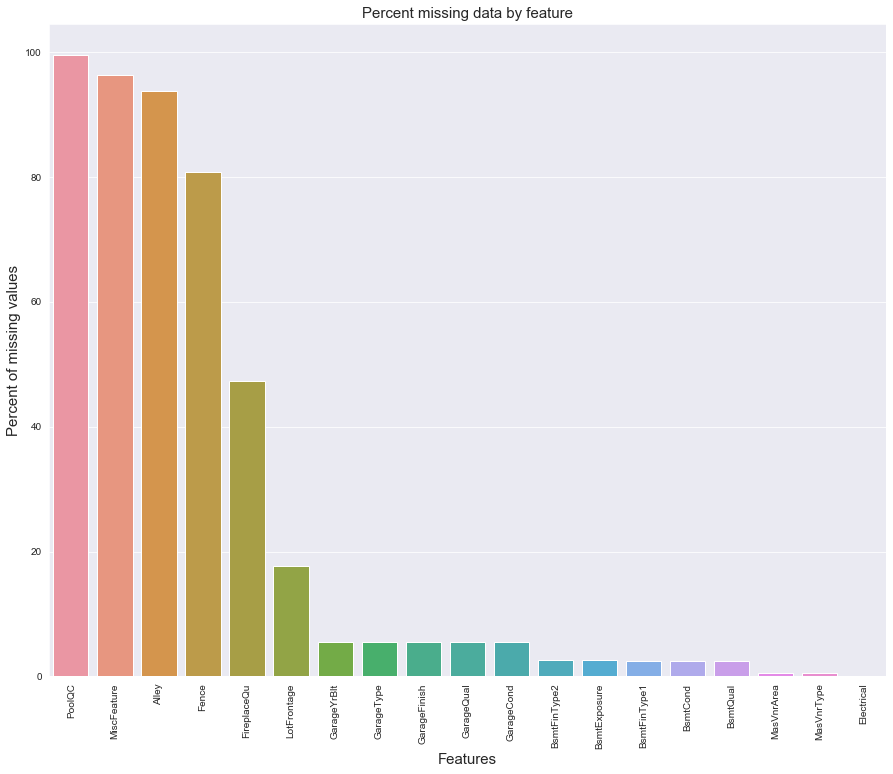

,Missing Ratio
PoolQC,99.521
MiscFeature,96.301
Alley,93.767
Fence,80.753
FireplaceQu,47.260
LotFrontage,17.740
GarageYrBlt,5.548
GarageType,5.548
GarageFinish,5.548
GarageQual,5.548


In [10]:
missing_train = check_miss_data(train,30)
missing_train

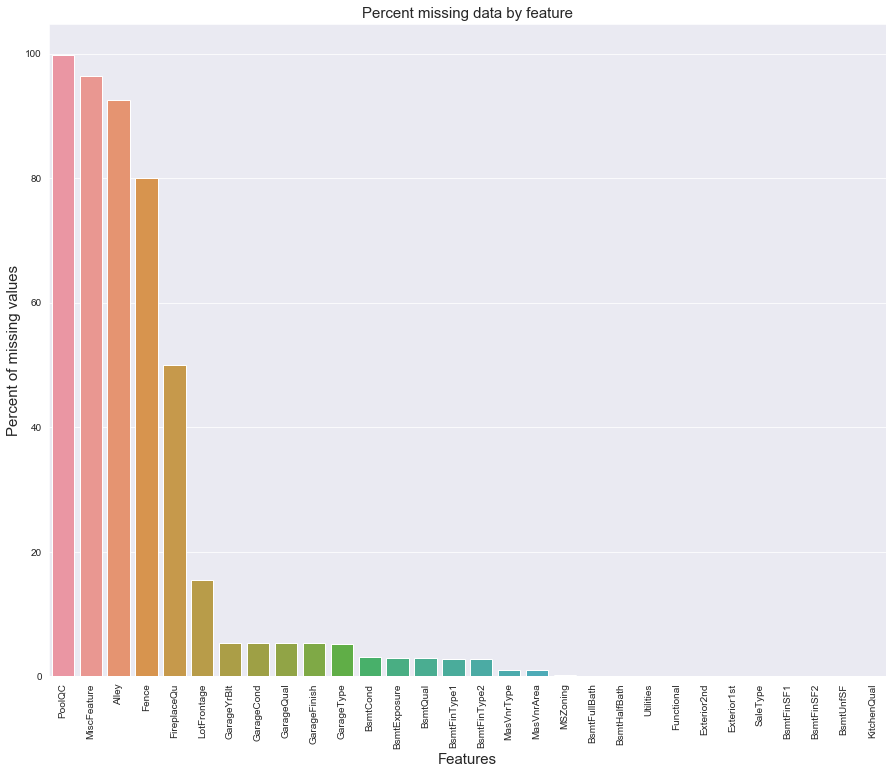

,Missing Ratio
PoolQC,99.794
MiscFeature,96.504
Alley,92.666
Fence,80.123
FireplaceQu,50.034
LotFrontage,15.559
GarageYrBlt,5.346
GarageCond,5.346
GarageQual,5.346
GarageFinish,5.346


In [11]:
missing_test = check_miss_data(test,30)
missing_test

let's do missing value imputation (details of why we do certain things is outside the scope of this notebook. Those are based on separate EDA)

In [12]:
def miss_val_impute(df):
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    for col in ('PoolQC','MiscFeature','Alley','Fence','GarageType','FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df = df.drop(['Utilities'], axis=1)
    df["Functional"] = df["Functional"].fillna("Typ")
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    return df


In [13]:
train = miss_val_impute(train)
test = miss_val_impute(test)
train.shape, test.shape

((1460, 81), (1459, 79))

# Create new features

In [14]:
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

In [15]:
def new_feats(df):
    #MSSubClass=The building class
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    #Changing OverallCond into a categorical variable
    df['OverallCond'] = df['OverallCond'].astype(str)
    #Year and month sold are transformed into categorical features.
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    return df

In [16]:
train = new_feats(train)
test = new_feats(test)

In [17]:
train.shape,test.shape

((1460, 82), (1459, 80))

# Methods for explaining any one type of model

# 1) Permutation Importance

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [19]:
y = train["ln_SalePrice"]  
feature_names = [col for col in train.columns if col not in ['ln_SalePrice','SalePrice','Id'] and train[col].dtype in [np.int64]]
X = train[feature_names]

In [20]:

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestRegressor(random_state=0).fit(train_X, train_y)

In [21]:
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.3498 ± 0.0302,TotalSF
0.1912 ± 0.0394,OverallQual
0.0192 ± 0.0059,YearRemodAdd
0.0187 ± 0.0127,YearBuilt
0.0141 ± 0.0043,OverallCond
0.0124 ± 0.0034,GrLivArea
0.0121 ± 0.0039,LotArea
0.0106 ± 0.0034,GarageArea
0.0105 ± 0.0033,GarageCars
0.0047 ± 0.0019,BsmtQual


# How to interpret permutation importance

Premutation importance, also known as Mean Decrease in Accuracy. This is based on experiments on out of bag (OOB) samples, via destroying the predictive power without changing it's marginal distribution. 

Permutation importance as per Element of Statistical Learning is described as "When the bth tree is grown, the OOB samples are passed down the tree, and the prediction accuracy is recorded. Then the values for the jth variable are randomly permuted in the OOB samples, and the accuracy is again computed. The decrease in accuracy as a result of this permuting is averaged over all trees, and is used as a measure of the importance of variable j in the random forest. The randomization effectively voids the effect of a variable, much like setting a coefficient to zero in a linear model. This does not measure the effect on prediction were this variable not available, because if the model was refitted without the variable, other variables could be used as surrogates."

The features at the top show the most important features, while the ones at the bottom are the least important features.

The first number in each row shows how the model performance decreased with a random shuffling (in this case, using "mse" as the performance metric).

The number after +/- sign shows the variance of the performance measure from one re-shuffle to the other. 

# 2) SHAP Values

In [22]:
## There maybe issues with some versions of numpy with SHAP. You may see an error message like "ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'"
## In such cases it's recommended that you upgrade all packages using conda "conda update -all"
import shap

In [35]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
my_model.predict(data_for_prediction_array)
explainer = shap.TreeExplainer(my_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [37]:
my_model.predict(data_for_prediction_array)

array([12.76069337])

In [36]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

How do we interpret this?

Notice the term written as 'base value'? Base value is the average prediction across the prediction samples chosen. An analogue to this could be the 'Intercept' term of a simple linear regression which shows the predicted value in the absence of any other predictor.

For each individual Shapley value, phi_ij for some feature j and some row x_i, is interpreted as follows: the feature value x_ij contributed phi_ij towards the prediction, yhat_i, for instance x_i compared to the average prediction for the dataset, i.e. mean(yhat).

In this case the features 'TotalSF' and 'OverallQual' have the biggest positive impact in pushing the predicted value above the base value.

In [50]:
k_explainer = shap.KernelExplainer(my_model.predict, train_X)
k_shap_values = k_explainer.shap_values(val_X)
shap.force_plot(k_explainer.expected_value, k_shap_values, val_X)

Using 1095 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [1:16:35<00:00, 12.54s/it]


The chart above shows a generalized view of predictions across all the validation samples. Hover over each point to see which points are the highest influencer in getting a prediction above the average (shown in pink) and which ones are pushing the prediction below the average prediction value.

Intrestingly the top factors pushing the value above the base value are more or less the same for all the validation examples i.e. 'TotalSF' and 'OverallQual'. But their magnitude varies by each example.

# Overfit/Underfit and Optimizing model hyperparameters

When a model is able to capture the variation on training data but is unable to do the same in test data - we term it as Overfitting. This will be typically seen by a divergence between the training and test evaluation metrics. On the other end of spectrum we have a case where the model does poorly even on the training data. This situation is known as Underfitting. Optimizing the hyperparameters is one way of reducing underfitting/overfitting. In the example below, we show the example of optimizing the 'max_depth' parameter of a DecisionTree Regressor (in this example, the algorithm didn't underfit much - but a similar method of diagnosis should hold true in the case of underfitting as well)

In [27]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

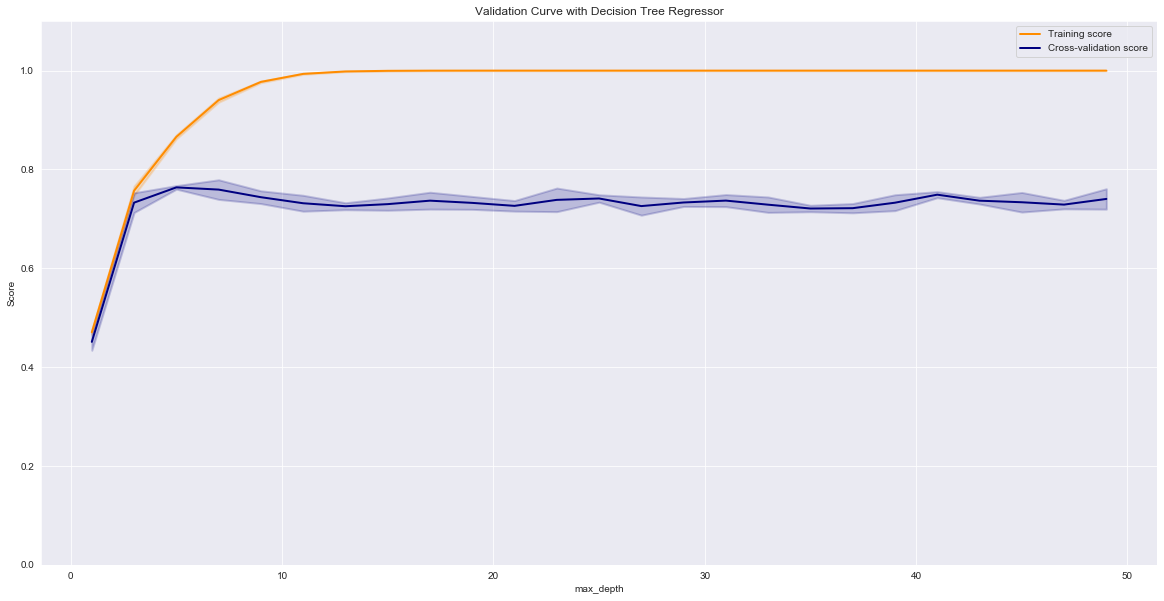

In [41]:
param_range = np.arange(1, 50, 2)
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(), train_X, train_y, param_name="max_depth", param_range=param_range,
    cv=None, scoring="explained_variance", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,10))
plt.title("Validation Curve with Decision Tree Regressor")
plt.xlabel("max_depth")
#plt.xticks(param_range)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

plt.show()

# Choosing a good model validation strategy

Model validation is one of the most important things that one must do to avoid building models that underfit/overfit. The strategy that I would recommend is to typically break the training data into three parts:
 1) Training sample
 2) Dev sample (for doing validations during training)
 3) Test sample - kept completly separate from the previous data. Test sample is to be used only when the model build is finalized between training and dev sample.
 
This approach, however, has one problem. During training we are not able to utilize all the data. Between the training and dev sample, the dev sample is never utilized for training and this could mean loss of meaningful information. To avoid this we will utilize 'k-fold' cross validation strategy. Here the training data is split into k folds. The model is run k times, where k-1 folds are used for training and 1 fold is held out for validation. This is done until each fold is used as a validation sample. The final model result is achieved by averaging the predictions of the k models.

Let's look at this in the form on an example.

In [82]:
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
from sklearn.metrics import mean_squared_error

We now define the folds for cross validation

In [114]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = [col for col in train.columns if col not in ['ln_SalePrice','SalePrice','Id'] and train[col].dtype in [np.int64]]

Let's define the model parameters

In [172]:
params = {'num_leaves': 35,
         'min_data_in_leaf': 10, 
          'min_sum_hessian_in_leaf': 5.0,
          'min_child_samples':10,
         'boost_from_average':'false',
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 42,
         "metric": 'mae',
         'reg_alpha': 0.4002,
         'reg_lambda':0.8003,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [173]:
train_X = train[train_columns]
test_X = test[train_columns]
train_y=train['SalePrice']

For the purposes of demonstration, since we do not have actual target values for the 'test' dataset provided by the competition data. Let's split the existing train dataset in train/test using train_test_split

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_train_X = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_test_X = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [176]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,y_train.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits
    
print("Overall CV score: {:<8.5f}".format(mean_absolute_error(y_train.values, oof)))

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 67565.8	valid_1's l1: 73705.8
[2000]	training's l1: 27103.6	valid_1's l1: 33372.7
[3000]	training's l1: 13203.7	valid_1's l1: 21321.6
[4000]	training's l1: 8859.39	valid_1's l1: 18101
[5000]	training's l1: 7245.77	valid_1's l1: 17306.4
[6000]	training's l1: 6317.21	valid_1's l1: 17117.3
Early stopping, best iteration is:
[6440]	training's l1: 5998.88	valid_1's l1: 17107.8
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 68234.4	valid_1's l1: 68306.9
[2000]	training's l1: 27623.3	valid_1's l1: 29059.6
[3000]	training's l1: 13686.7	valid_1's l1: 17197.3
[4000]	training's l1: 9352.08	valid_1's l1: 14685
[5000]	training's l1: 7693.77	valid_1's l1: 14057
[6000]	training's l1: 6736.23	valid_1's l1: 13923.2
[7000]	training's l1: 6013.96	valid_1's l1: 13865
[8000]	training's l1: 5410.76	valid_1's l1: 13835.7
Early stopping, best iteration is:
[8155]	training's 

In [177]:
print("Overall CV score: {:<8.5f}".format(mean_absolute_error(y_test.values, predictions)))

Overall CV score: 16701.26143


let's look at the feature importance averaged across the k=5 folds.

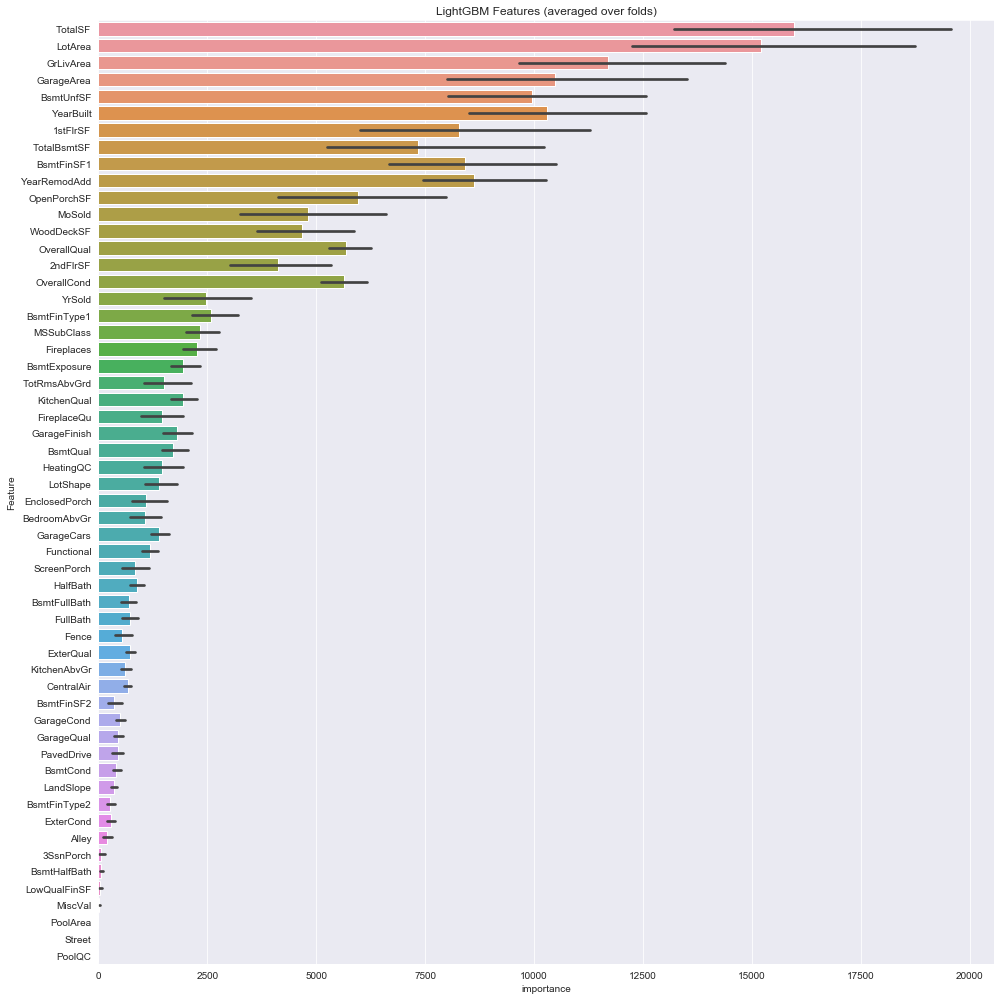

In [178]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

We can also use cross_val_score function of Sklearn to do this for many classes of models

In [186]:
n_folds = 5

def mae_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    mae= -cross_val_score(model, X_train.values, y_train, scoring="neg_mean_absolute_error", cv = kf)
    return(mae)

# Ensembling different models

As you may have noticed, the LightGBM model doesn't rank 'TotalSF' and 'OverallQual' as the top two features like RandomForest. This essentially points to the fact that each model is a little different in the way it captures variation across the training data. Combining them may point us to a way of getting predictions that can cover variation more than any single model does on its own.

To look at this let's train some base models first.

In [135]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [208]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=35,
                              learning_rate=0.001, n_estimators=20000,
                              max_bin = 55, bagging_fraction = 0.7,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9,
                              min_data_in_leaf =10, min_sum_hessian_in_leaf = 5.0,max_depth=-1,
                             bagging_seed=42,reg_alpha=0.4002,reg_lambda=0.8003,random_state=42)

Let's review each of these model types on how they perform on their own using k-fold cross validation

In [187]:
score = mae_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 19038.5609 (1271.9582)



In [188]:
score = mae_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 19039.2089 (1271.6375)



In [190]:
score = mae_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 15809.5996 (1819.2820)



In [209]:
score = mae_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 16112.7915 (1899.3218)



# Stacking models

Simplest way of stacking models is to average the predictions. Let's look at that case first

In [192]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

Let's try combining three models by averaging and see what sort of results we get

In [211]:
averaged_models = AveragingModels(models = (ENet, model_lgb, lasso))

score = mae_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 16757.8856 (1487.3569)



Averaging these 3 models didn't end up giving a model than all three. In this case the single lightgbm model is still the better option. Will averaging four models give any better results?? let's find out

In [212]:
averaged_models = AveragingModels(models = (ENet, GBoost,model_lgb, lasso))

score = mae_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 15934.2182 (1537.7022)



Well this did improve the CV score compared to previous average, but this is still not the best. the GBoost regressor still outscores the ensemble. In this case it can be treated as the 'Champion' model. However, in many cases you will get the result which is better than all base models.

Let's now train and predict to check the fit against the actual values

In [221]:
ENet.fit(X_train, y_train)
ENet_pred = ENet.predict(X_test)
print("Actual score ENet: {:<8.5f}".format(mean_absolute_error(y_test.values, ENet_pred)))

Actual score ENet: 22015.36264


In [222]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print("Actual score lasso: {:<8.5f}".format(mean_absolute_error(y_test.values, lasso_pred)))

Actual score lasso: 22017.96550


In [224]:
GBoost.fit(X_train, y_train)
GBoost_pred = GBoost.predict(X_test)
print("Actual score GBoost: {:<8.5f}".format(mean_absolute_error(y_test.values, GBoost_pred)))

Actual score GBoost: 16769.45693


In [225]:
model_lgb.fit(X_train, y_train)
model_lgb_pred = model_lgb.predict(X_test)
print("Actual score LightGBM: {:<8.5f}".format(mean_absolute_error(y_test.values, model_lgb_pred)))

Actual score LightGBM: 16435.74211


In [229]:
averaged_pred = np.mean([ENet_pred,lasso_pred,GBoost_pred,model_lgb_pred], axis=0)

In [233]:
print("Actual score straight avg of all four models: {:<8.5f}".format(mean_absolute_error(y_test.values, averaged_pred)))

Actual score straight avg of all four models: 18281.61067


In [256]:
averaged_pred_diff_wt = 0.58*model_lgb_pred+0.4*GBoost_pred+0.01*lasso_pred+0.01*ENet_pred
print("Actual score different weights for all models: {:<8.5f}".format(mean_absolute_error(y_test.values, averaged_pred_diff_wt)))

Actual score different weights for all models: 16294.63125


We arrived at these weights by trying a range of weights and observing the results. That method is beyond the scope of this notebook. However,as you may have noticed with this type of mixing the resulting model is performing better than any single model on it's own.

Now let's look at some other form of stacking which is a little less simple than using weighted averages.


Meta model based stacking

In this approach, we add a higher level model  on averaged base models and use the out-of-fold predictions of these base models to train the higher level model (also called meta-model).

Following steps are used to create a meta-model based model stacker:

1) Split the total training set into two disjoint sets (here train and .holdout )


2) Train several base models on the first part (train)


3) Test these base models on the second part (holdout)

4) Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.


The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

Now, one option would be to write this entire process on your own. However, for the purposes of this illustration we will use a stacking library called 'vecstack' https://github.com/vecxoz/vecstack

This library is compatible with almost all of the known algorithms and makes it really easy to integrate with Scikit-learn pipelines.

In [195]:
from vecstack import stacking

In [196]:
models = [
    ENet, GBoost,model_lgb, lasso
]

In [197]:
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=mean_absolute_error, # metric: callable
                           n_folds=5,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [Pipeline]
    fold  0:  [18939.38085165]
    fold  1:  [20471.73445225]
    fold  2:  [18366.02893590]
    fold  3:  [21286.69750714]
    fold  4:  [17351.91887350]
    ----
    MEAN:     [19283.15212409] + [1422.38374225]
    FULL:     [19283.09021302]

model  1:     [GradientBoostingRegressor]
    fold  0:  [14060.61753168]
    fold  1:  [16186.05107278]
    fold  2:  [15819.80587226]
    fold  3:  [17299.93148459]
    fold  4:  [14779.27417455]
    ----
    MEAN:     [15629.13602717] + [1124.32933410]
    FULL:     [15628.43317306]

model  2:     [LGBMRegressor]
    fold  0:  [14355.72793852]
    fold  1:  [17181.95258373]
    fold  2:  [16936.64105278]
    fold  3:  [17675.84955181]
    fold  4:  [14412.37070366]
    ----
    MEAN:     [16112.50836610] + [1431.34110713]
    FULL:     [16112.62548637]

model  3:     [Pipeline]
    fold  0:  [18940.72232610]
 

In [201]:
from xgboost import XGBRegressor

In [202]:
model = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                     n_estimators=100, max_depth=3)      ##We use xgboost as the meta-model in this case
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % mean_absolute_error(y_test, y_pred))

Final prediction score: [17142.92868418]


We have not done any hyperparameter tuning of meta model. However, with proper tuning one can achieve same or better results than the weighted averaged stacked model example.

# If you found this notebook useful then a 'Star' on the repository would be much appreciated. This will motivate me to keep updating this repository on a regular basis.